In [2]:
import datetime
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Подход 1: Градиентный бустинг ##

Считаем таблицу с принками файла 

Удалим признаки, связанные с итогами матча

***Почему градинтный бустинг?***
Он не очень требователен к данным, восстанавливает нелинейные зависимости, и хорошо работает на многих наборах данных, что и обуславливает его популярность. 

In [3]:
train = pd.read_csv('features.csv', index_col="match_id")
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [23]:
train.drop([
    "duration",
    "tower_status_radiant",
    "tower_status_dire",
    "barracks_status_radiant",
    "barracks_status_dire",
], axis=1, inplace=True)

#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

Выведем нулевые значения:

In [24]:
train.isnull().sum().sort_values(ascending=False)

first_blood_player2            43987
radiant_flying_courier_time    27479
dire_flying_courier_time       26098
first_blood_time               19553
first_blood_team               19553
                               ...  
d3_kills                           0
d3_deaths                          0
d3_items                           0
d4_hero                            0
start_time                         0
Length: 103, dtype: int64

Чтобы было удобнее, выведем долю ненулевых значений. 

In [25]:
na_table = train.isnull().sum()
na_table[na_table > 0].sort_values(ascending=False) /  len(train)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_player1            0.201100
first_blood_team               0.201100
first_blood_time               0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

Проанализируем, что означают отсутвующие значения?

* `first_blood_player2` (второй игрок, причастный к событию) - означает, что в первые пять минут, если и происходило событие "первая кровь", то один персонаж убивал другого чаще по одиночке. 
* `radiant_flying_courier_time` (время приобретения предмета "flying_courier"). он оначинает быть доступен только в 3 минуту, и в 28 % случаев команды не покупают его сразу за 2 минуты.
* `dire_flying_courier_time` (время приобретения предмета "flying_courier").аналогичное объяснение для команды соперников
* `first_blood_player1`, `first_blood_team`, `first_blood_time` - пропущенные значения в этих колонках означает, что первое убийство игрока игроком не произошло в первые 5 минут. B
* `dire_bottle_time` `radiant_bottle_time `(время первого приобретения командой предмета "bottle") - означает, что в 16 %  случаев бутылку не покупали в начале игры
* `radiant_first_ward_time' 'dire_first_ward_time` ( время установки командой первого "наблюдателя") - очень редкое явление
* `radiant_courier_time` (время приобретения предмета "courier") - также редкое явление в обоих командах 


сравним различные подходы к обработке пропущенных значений?

In [26]:
data0 = train.fillna(0) # пропуски заполнены нулями
data1 = train.fillna(train.mean()) # пропуски заполнены средним значением
data2 = train.fillna(train.max()) # пропуски заполнены максимальным значением

***Целевая переменная содержится в "radiant_win"***

In [27]:
X_0 = data0.drop('radiant_win', axis=1)
y_0 = data0['radiant_win']

In [28]:
X_1 = data1.drop('radiant_win', axis=1)
y_1 = data1['radiant_win']

In [29]:
X_2 = data2.drop('radiant_win', axis=1)
y_2 = data2['radiant_win']

### Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки" ###

In [30]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [31]:
def score_gb(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    scores = {}

    for n_estimators in [10, 20, 30, 50]:
        print(f"n_estimators={n_estimators}")
        model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")

        scores[n_estimators] = score
        print()
        
    return pd.Series(scores)

n_estimators=10
Score: 0.665
Time elapsed: 0:00:29.000312

n_estimators=20
Score: 0.682
Time elapsed: 0:00:52.662484

n_estimators=30
Score: 0.690
Time elapsed: 0:01:20.297742

n_estimators=50
Score: 0.697
Time elapsed: 0:02:08.524599



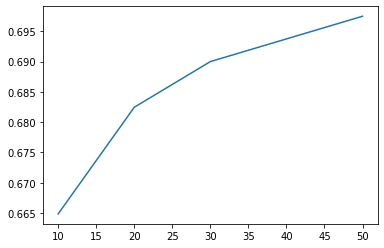

In [32]:
scores = score_gb(X_0, y_0)
scores.plot()

**Можно сказать, что взять n_estimators=30 самое оптимальное, потому что реализация алгоритма занимает только полторы минуты, а качество не сильно отличается от n_estimators=50** 

**Попробуем поменять данные**

n_estimators=10
Score: 0.663
Time elapsed: 0:00:27.465750

n_estimators=20
Score: 0.682
Time elapsed: 0:00:56.643395

n_estimators=30
Score: 0.689
Time elapsed: 0:01:19.159689

n_estimators=50
Score: 0.697
Time elapsed: 0:02:09.814704



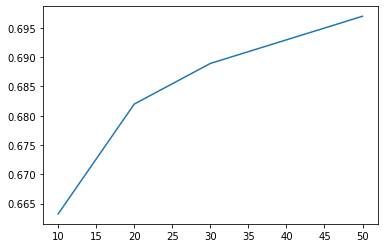

In [33]:
scores = score_gb(X_1, y_1)
scores.plot()

n_estimators=10
Score: 0.666
Time elapsed: 0:00:32.612144

n_estimators=20
Score: 0.683
Time elapsed: 0:01:01.800073

n_estimators=30
Score: 0.690
Time elapsed: 0:01:29.667680

n_estimators=50
Score: 0.698
Time elapsed: 0:02:30.714941



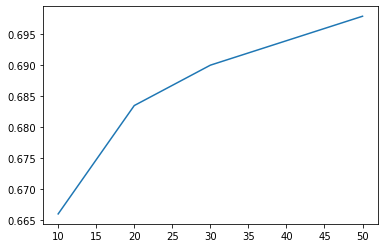

In [34]:
scores = score_gb(X_2, y_2)
scores.plot()

***Таким образом можно сделать вывод в данной задаче практически не важно чем мы заполняем пропущенные значения. НО хочентся обратить внимание, что все-таки лучше заполнять их в случае с деревьями максимальными значениями или нулевыми — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева.***

## Подход 2:  логистическая регрессия ##

**Почему она?**
Потому что линейные регрессии работают гораздо быстрее деревьев. Сравним

In [37]:
scaler = StandardScaler()

In [37]:
X_log0 = pd.DataFrame(scaler.fit_transform(X_0), index=X_0.index, columns=X_0.columns)

In [38]:
X_log1 = pd.DataFrame(scaler.fit_transform(X_1), index=X_1.index, columns=X_1.columns)

In [39]:
X_log2 = pd.DataFrame(scaler.fit_transform(X_2), index=X_2.index, columns=X_2.columns)

In [40]:
def score_lr(X: pd.DataFrame, y: pd.Series) -> pd.Series:
    scores = {}

    for i in range(-5, 6):
        C = 10.0 ** i

        print(f"C={C}")
        model = LogisticRegression(C=C, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")

        scores[i] = score
        print()

    return pd.Series(scores)

C=1e-05
Score: 0.695
Time elapsed: 0:00:01.449831

C=0.0001
Score: 0.711
Time elapsed: 0:00:01.832242

C=0.001
Score: 0.716
Time elapsed: 0:00:02.894974

C=0.01
Score: 0.717
Time elapsed: 0:00:03.325659

C=0.1
Score: 0.717
Time elapsed: 0:00:03.619801

C=1.0
Score: 0.717
Time elapsed: 0:00:03.203951

C=10.0
Score: 0.717
Time elapsed: 0:00:03.235447

C=100.0
Score: 0.717
Time elapsed: 0:00:03.243002

C=1000.0
Score: 0.717
Time elapsed: 0:00:03.273489

C=10000.0
Score: 0.717
Time elapsed: 0:00:03.771603

C=100000.0
Score: 0.717
Time elapsed: 0:00:03.732042



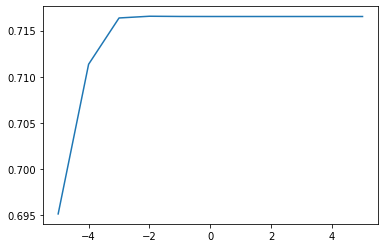

In [44]:
scores = score_lr(X_log0, y_0)
scores.plot()

C=1e-05
Score: 0.695
Time elapsed: 0:00:01.637527

C=0.0001
Score: 0.712
Time elapsed: 0:00:01.709809

C=0.001
Score: 0.717
Time elapsed: 0:00:02.798944

C=0.01
Score: 0.717
Time elapsed: 0:00:03.305330

C=0.1
Score: 0.717
Time elapsed: 0:00:03.274849

C=1.0
Score: 0.717
Time elapsed: 0:00:03.108594

C=10.0
Score: 0.717
Time elapsed: 0:00:03.187782

C=100.0
Score: 0.717
Time elapsed: 0:00:03.280694

C=1000.0
Score: 0.717
Time elapsed: 0:00:03.411590

C=10000.0
Score: 0.717
Time elapsed: 0:00:03.111166

C=100000.0
Score: 0.717
Time elapsed: 0:00:03.426092



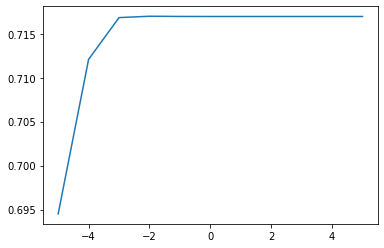

In [45]:
scores = score_lr(X_log1, y_1)
scores.plot()

C=1e-05
Score: 0.696
Time elapsed: 0:00:01.595068

C=0.0001
Score: 0.712
Time elapsed: 0:00:01.524608

C=0.001
Score: 0.717
Time elapsed: 0:00:02.329074

C=0.01
Score: 0.717
Time elapsed: 0:00:02.946961

C=0.1
Score: 0.717
Time elapsed: 0:00:03.208846

C=1.0
Score: 0.717
Time elapsed: 0:00:03.200605

C=10.0
Score: 0.717
Time elapsed: 0:00:03.205773

C=100.0
Score: 0.717
Time elapsed: 0:00:03.464018

C=1000.0
Score: 0.717
Time elapsed: 0:00:03.215233

C=10000.0
Score: 0.717
Time elapsed: 0:00:03.209121

C=100000.0
Score: 0.717
Time elapsed: 0:00:03.186655



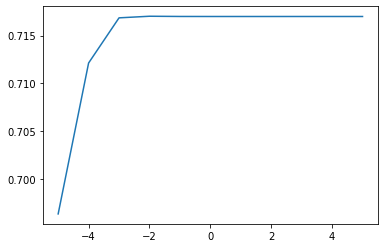

In [46]:
scores = score_lr(X_log2, y_2)
scores.plot()

**Теперь уберем  категориальные переменные**

In [51]:
hero_columns = [f"r{i}_hero" for i in range (1, 6)] + [f"d{i}_hero" for i in range (1, 6)]
cat_columns = ["lobby_type"] + hero_columns
X_log0.drop(cat_columns, axis=1, inplace=True)

C=1e-05
Score: 0.695
Time elapsed: 0:00:01.371515

C=0.0001
Score: 0.711
Time elapsed: 0:00:01.466050

C=0.001
Score: 0.716
Time elapsed: 0:00:02.233286

C=0.01
Score: 0.717
Time elapsed: 0:00:02.850733

C=0.1
Score: 0.717
Time elapsed: 0:00:04.044462

C=1.0
Score: 0.717
Time elapsed: 0:00:03.518026

C=10.0
Score: 0.717
Time elapsed: 0:00:03.169954

C=100.0
Score: 0.717
Time elapsed: 0:00:03.439654

C=1000.0
Score: 0.717
Time elapsed: 0:00:03.162892

C=10000.0
Score: 0.717
Time elapsed: 0:00:03.618730

C=100000.0
Score: 0.717
Time elapsed: 0:00:03.111809



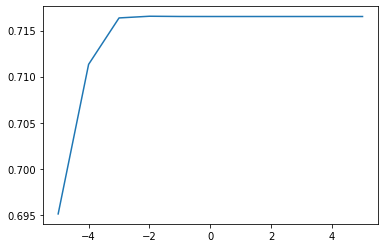

In [52]:
scores = score_lr(X_log0, y_0)
scores.plot()

***Удаление категориальных признаков не повлияло на качество предсказания. Получается, что в предыдущей модели эти признаки никак не влияли на результат предсказания, модель смогла распознать этот шум.***

На самом деле, следуя банальной логике, все-таки выбор героя важен в матчах. От этого зависит стратегия игроков и многое другое. 

Выясним из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [54]:
unique_heroes = np.unique(train[hero_columns].values.ravel())
N = max(unique_heroes)
print(f"Число уникальных героев в train: {len(unique_heroes)}. Максимальный ID героя: {N}.")

Число уникальных героев в train: 108. Максимальный ID героя: 112.


***Воспользуемся подходом "мешок слов" для кодирования информации о героях***

Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

In [55]:
def get_pick(data: pd.DataFrame) -> pd.DataFrame:
    X_pick = np.zeros((data.shape[0], N))

    for i, match_id in enumerate(data.index):
        for p in range(1, 6):
            X_pick[i, data.loc[match_id, f"r{p}_hero"] - 1] = 1
            X_pick[i, data.loc[match_id, f"d{p}_hero"] - 1] = -1

    return pd.DataFrame(X_pick, index=data.index, columns=[f"hero_{i}" for i in range(N)])

X_pick = get_pick(data0)
X_pick.head()

,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
X_log0 = pd.concat([X_log0, X_pick], axis=1)

C=1e-05
Score: 0.699
Time elapsed: 0:00:08.392610

C=0.0001
Score: 0.725
Time elapsed: 0:00:04.287844

C=0.001
Score: 0.746
Time elapsed: 0:00:06.339729

C=0.01
Score: 0.752
Time elapsed: 0:00:11.335525

C=0.1
Score: 0.752
Time elapsed: 0:00:14.050634

C=1.0
Score: 0.752
Time elapsed: 0:00:15.167145

C=10.0
Score: 0.752
Time elapsed: 0:00:12.247542

C=100.0
Score: 0.752
Time elapsed: 0:00:12.235868

C=1000.0
Score: 0.752
Time elapsed: 0:00:13.006046

C=10000.0
Score: 0.752
Time elapsed: 0:00:11.912242

C=100000.0
Score: 0.752
Time elapsed: 0:00:12.342706



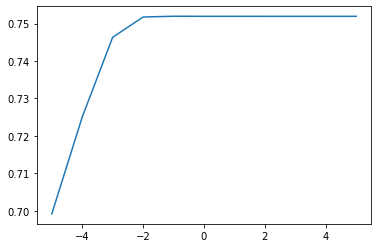

In [60]:
scores = score_lr(X_log0, y_0)
scores.plot()

***Наилучшее значение показателя AUC-ROC достигается при C = 0.10 и равно 0.75.
После добавления "мешка слов" по героям качество заметно улучшилось. Это объясняется тем, что вместо отсутствия данных о героях или случайного шума из id мы имеем осмысленную разреженную матрицу для построения предсказания.***

#### Построим предсказания вероятности победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации) ####

Убедимся, что предсказаные значения вероятности - адекватные(находятся в отрезке [0;1])

In [61]:
model = LogisticRegression(C=0.1, random_state=42)
model.fit(X_log0, y_0)

/Users/sandrayakimova/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1, random_state=42)

In [65]:
test = pd.read_csv("features_test.csv", index_col="match_id")
test.fillna(0, inplace=True)

In [66]:
test

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29.0,168.0,-54.0,0.0,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114369,1450212780,7,11,5,2054,1941,27,0,1,8,...,1,8.0,253.0,-87.0,0.0,4,3,2,1,-33.0
114377,1450222875,1,3,3,748,605,1,0,0,12,...,1,-1.0,133.0,-85.0,184.0,2,3,4,1,-18.0
114378,1450223593,1,85,2,575,499,0,0,0,8,...,0,20.0,133.0,-88.0,239.0,4,4,4,0,-36.0


In [67]:
X_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
X_test.drop(cat_columns, axis=1, inplace=True)
X_test = pd.concat([X_test, get_pick(test)], axis=1)
X_test.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
6,-2.528200,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.527214,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-2.525688,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-2.521671,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
16,-2.520369,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
preds = pd.Series(model.predict_proba(X_test)[:, 1])
preds.head()

0    0.808830
1    0.756139
2    0.176973
3    0.861803
4    0.232190
dtype: float64

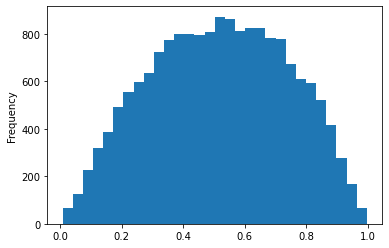

In [69]:
preds.plot.hist(bins=30)